# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

dataset_url = "Segmented Medicinal Leaf Images"
data_dir = pathlib.Path(dataset_url).with_suffix('')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1835


Here are some roses:

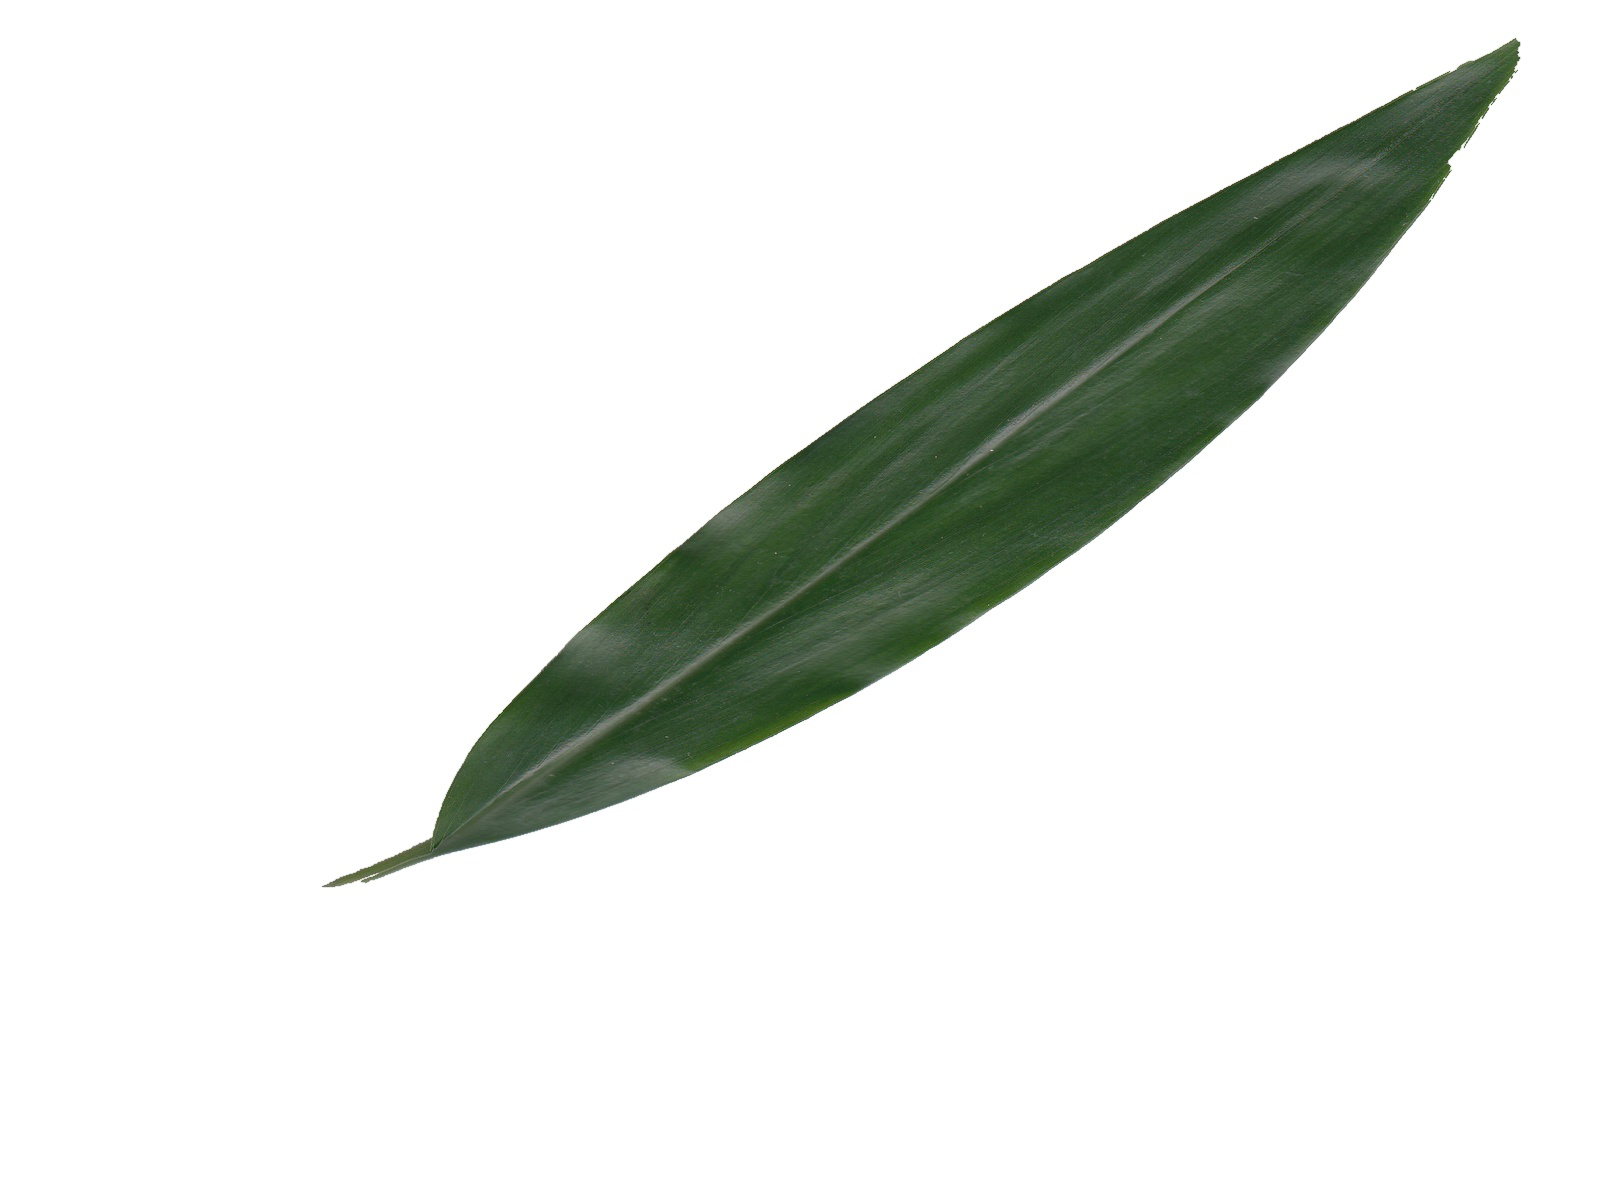

In [ ]:
roses = list(data_dir.glob('Alpinia Galanga (Rasna)/*'))
PIL.Image.open(str(roses[0]))

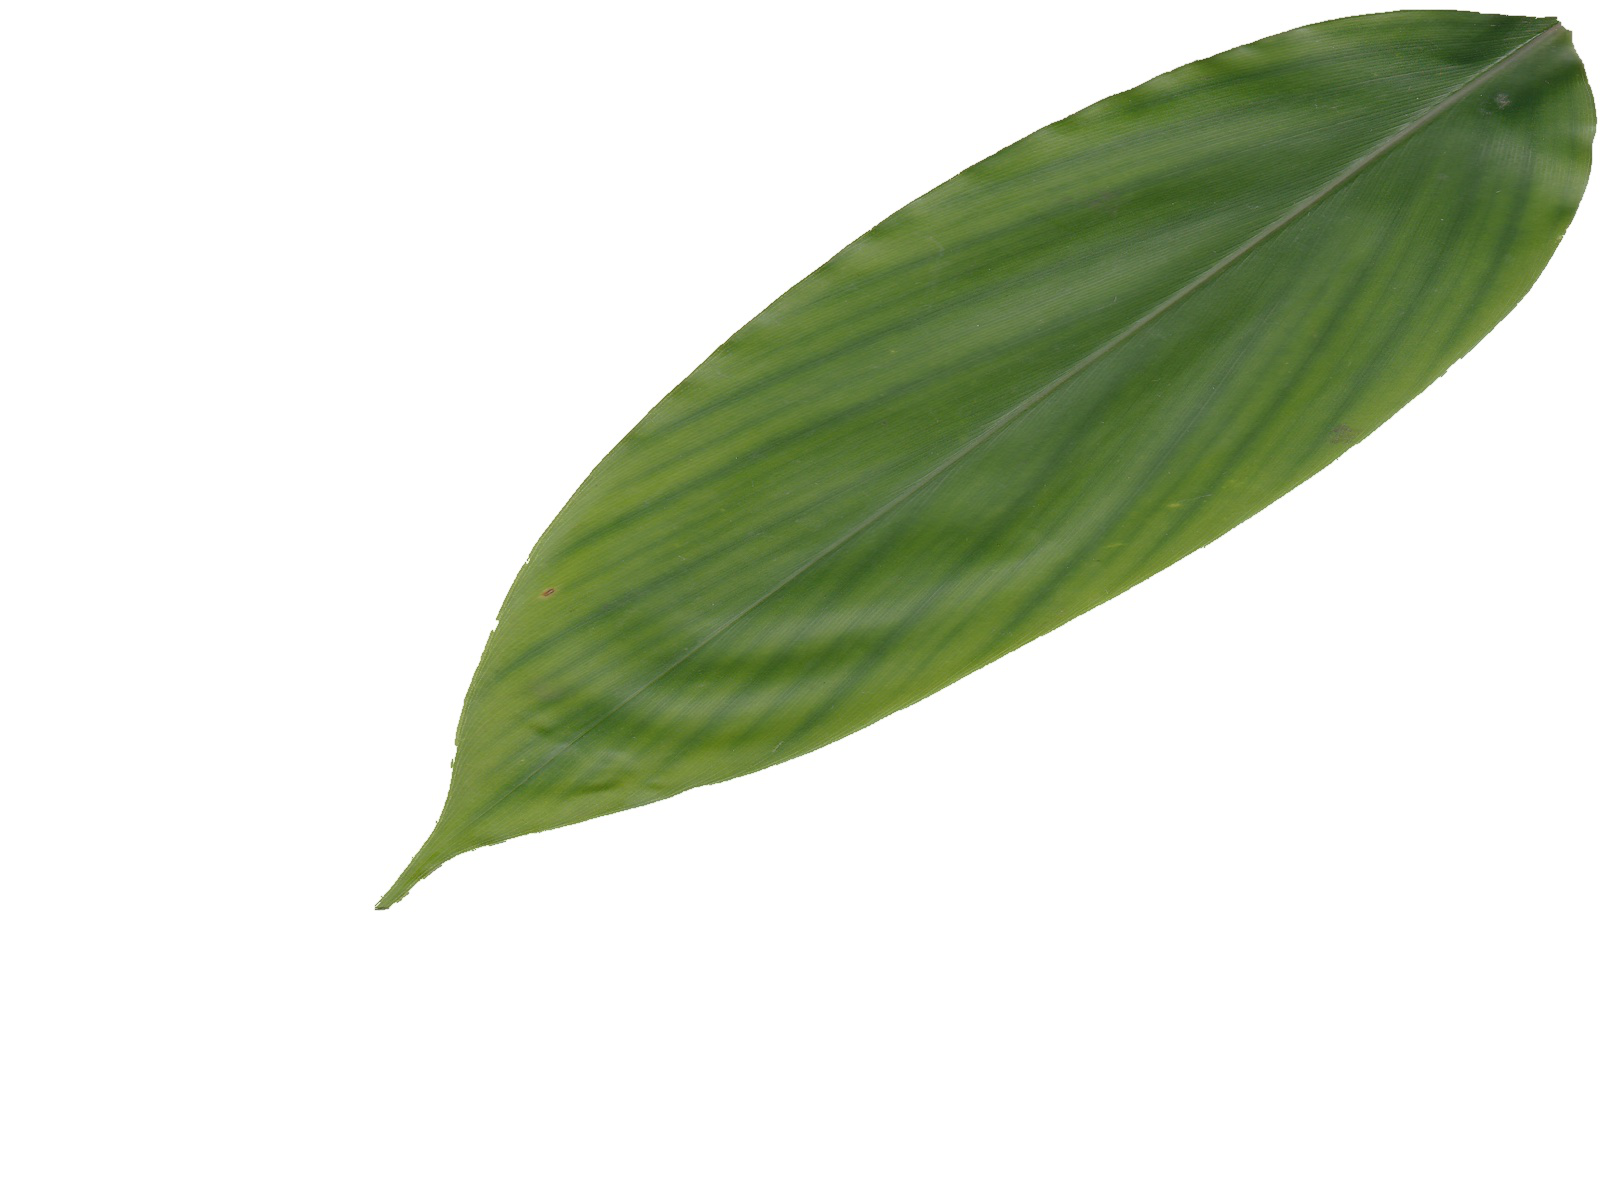

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

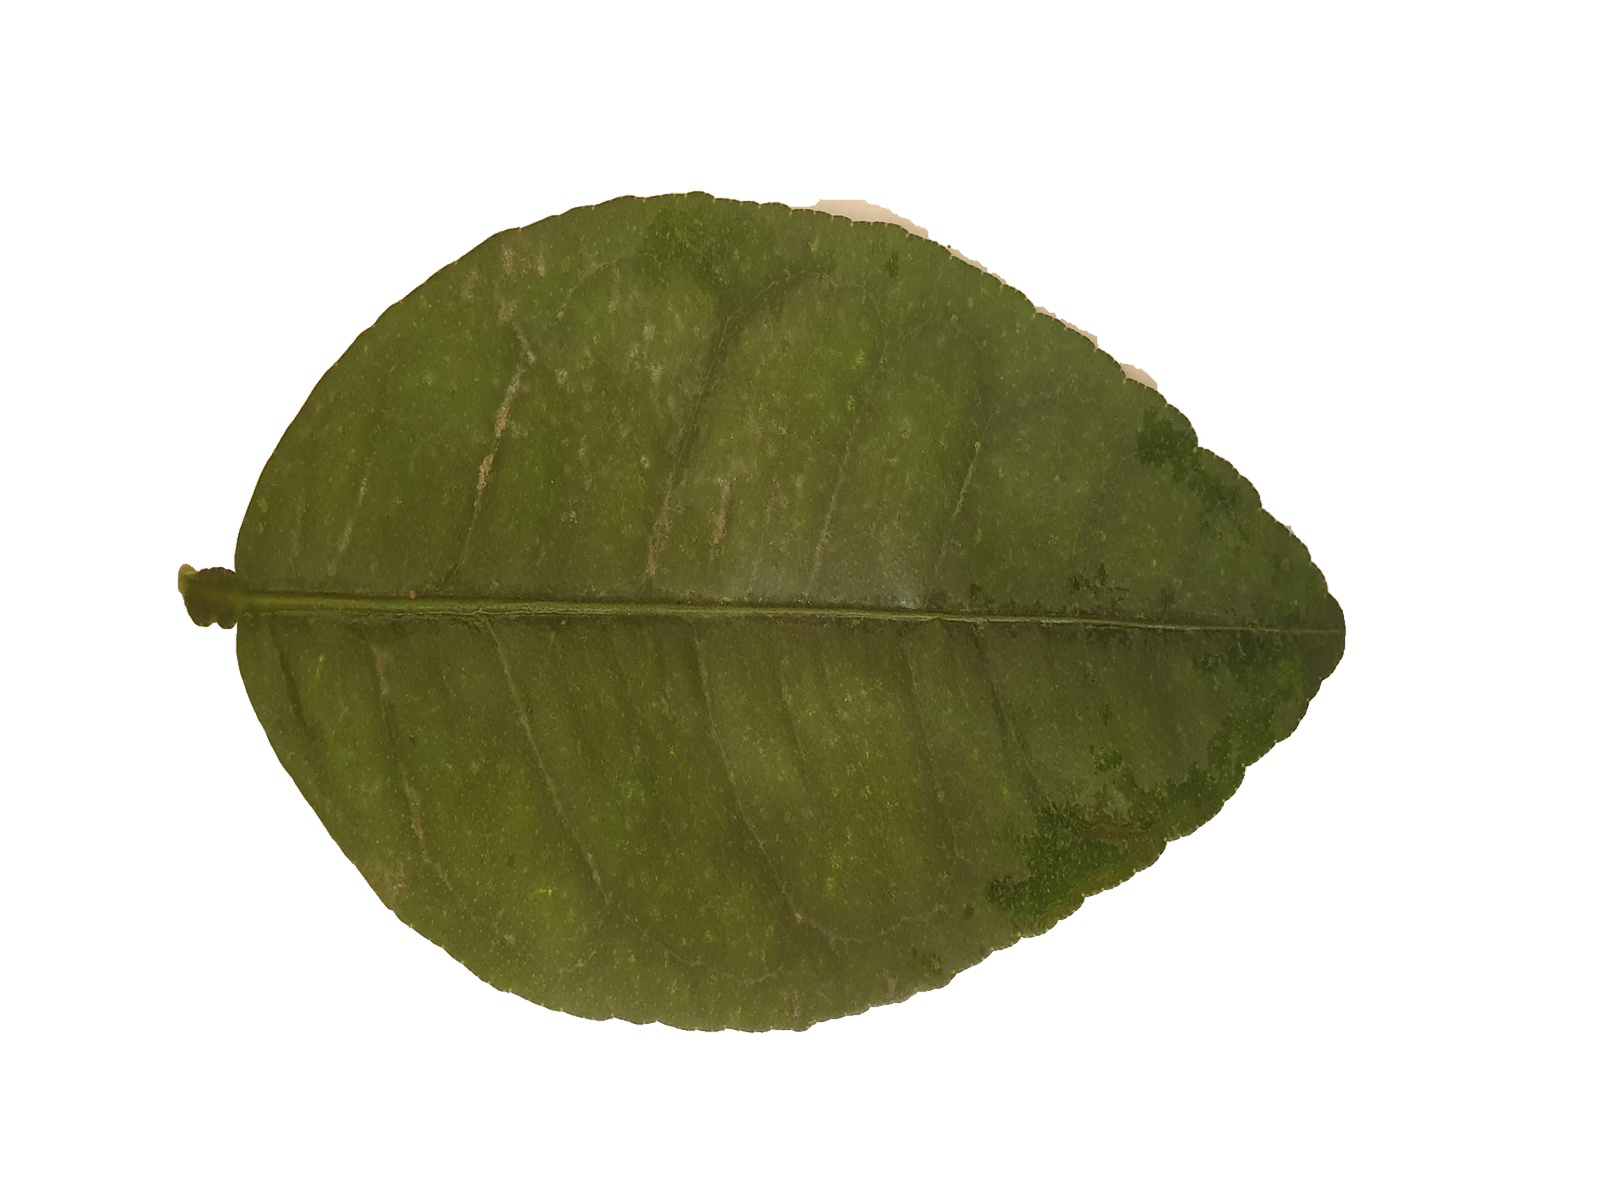

In [ ]:
tulips = list(data_dir.glob('Citrus Limon (Lemon)/*'))
PIL.Image.open(str(tulips[0]))

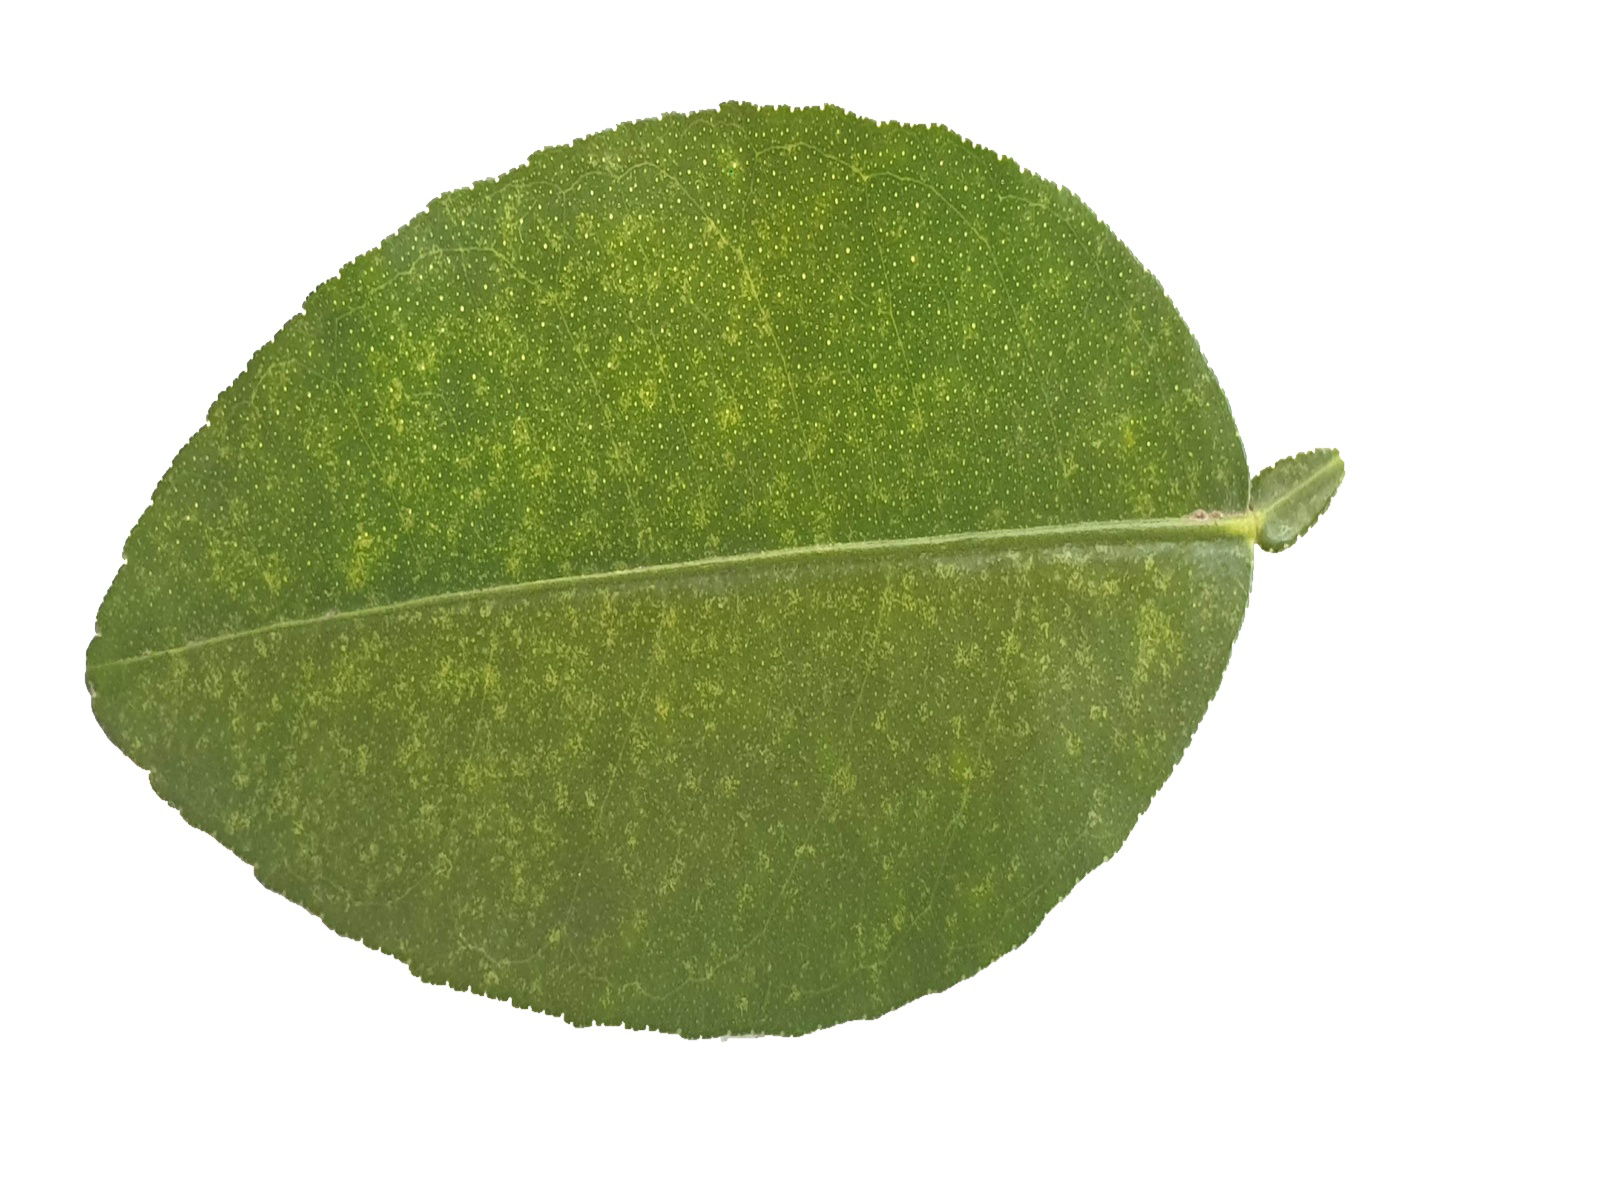

In [ ]:
PIL.Image.open(str(tulips[1]))

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1835 files belonging to 30 classes.
Using 1468 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1835 files belonging to 30 classes.
Using 367 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']


## Visualize the data

Here are the first nine images from the training dataset:

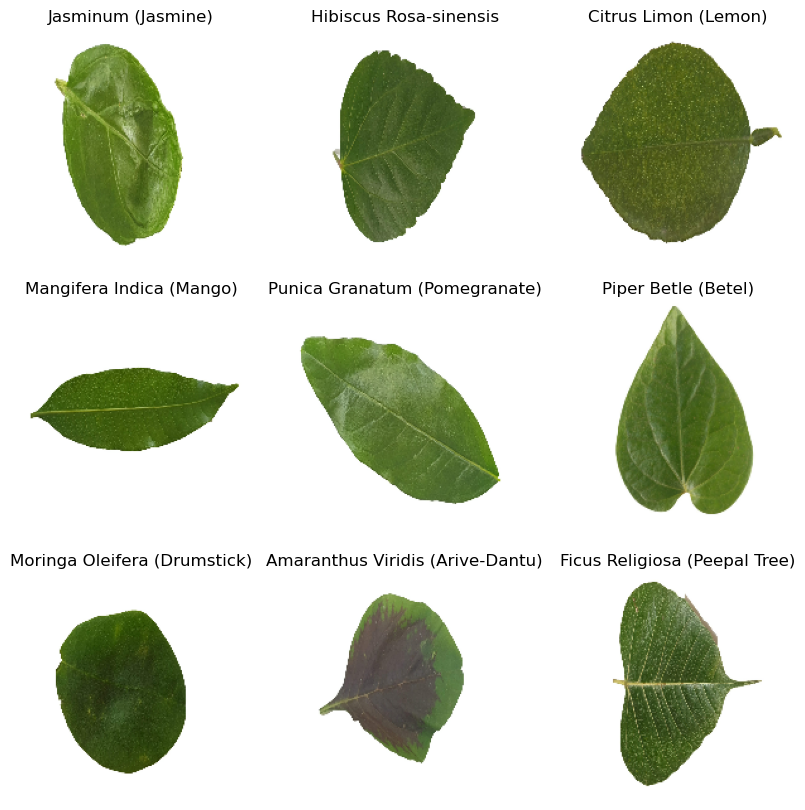

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13202551 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 30s 630ms/step - loss: 3.0944 - accuracy: 0.1771 - val_loss: 2.1811 - val_accuracy: 0.4332
Epoch 2/10
46/46 [==============================] - 28s 609ms/step - loss: 1.4363 - accuracy: 0.5974 - val_loss: 1.2436 - val_accuracy: 0.6349
Epoch 3/10
46/46 [==============================] - 28s 608ms/step - loss: 0.6803 - accuracy: 0.7956 - val_loss: 0.9459 - val_accuracy: 0.7057
Epoch 4/10
46/46 [==============================] - 28s 599ms/step - loss: 0.3926 - accuracy: 0.8774 - val_loss: 0.7337 - val_accuracy: 0.7793
Epoch 5/10
46/46 [==============================] - 28s 604ms/step - loss: 0.2534 - accuracy: 0.9244 - val_loss: 0.7189 - val_accuracy: 0.7956
Epoch 6/10
46/46 [==============================] - 28s 599ms/step - loss: 0.1220 - accuracy: 0.9605 - val_loss: 0.7044 - val_accuracy: 0.8256
Epoch 7/10
46/46 [==============================] - 28s 604ms/step - loss: 0.1125 - accuracy: 0.9639 - val_loss: 0.6968 - val_accuracy: 0.8147

## Visualize training results

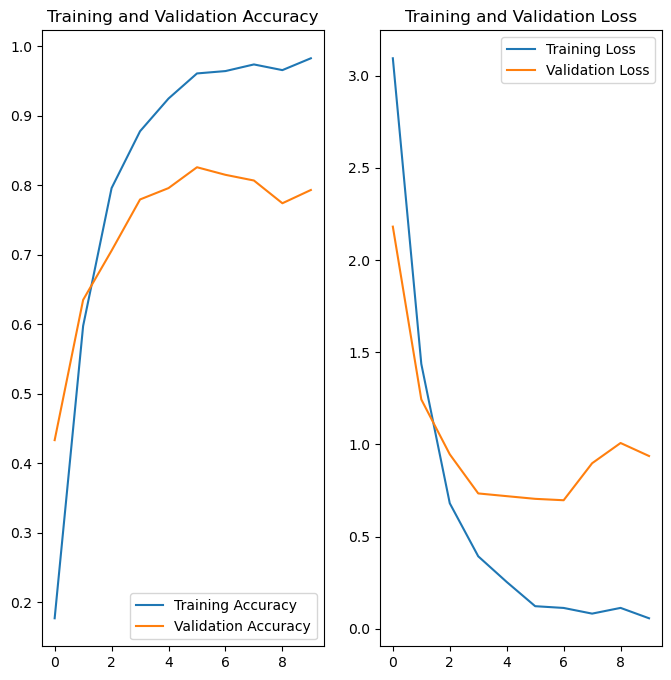

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

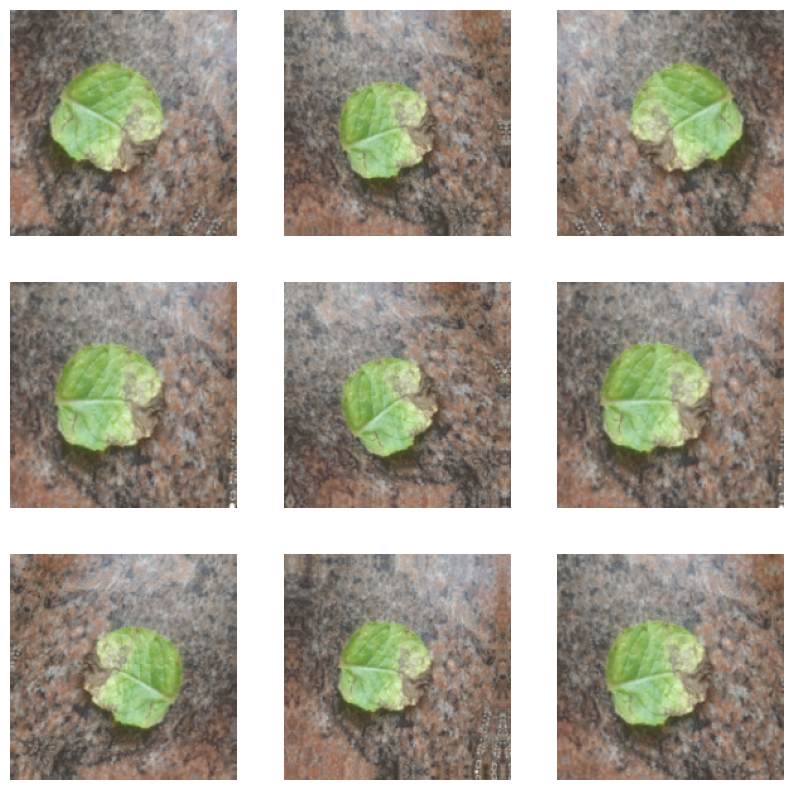

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
173/173 [==============================] - 118s 673ms/step - loss: 4.2322 - accuracy: 0.0422 - val_loss: 3.8442 - val_accuracy: 0.1036
Epoch 2/15
173/173 [==============================] - 121s 701ms/step - loss: 3.6283 - accuracy: 0.1317 - val_loss: 3.3776 - val_accuracy: 0.1797
Epoch 3/15
173/173 [==============================] - 117s 678ms/step - loss: 3.2033 - accuracy: 0.2004 - val_loss: 3.1173 - val_accuracy: 0.2304
Epoch 4/15
173/173 [==============================] - 123s 711ms/step - loss: 2.8944 - accuracy: 0.2697 - val_loss: 2.8984 - val_accuracy: 0.2725
Epoch 5/15
173/173 [==============================] - 117s 674ms/step - loss: 2.6401 - accuracy: 0.3176 - val_loss: 2.8979 - val_accuracy: 0.3080
Epoch 6/15
173/173 [==============================] - 121s 700ms/step - loss: 2.3962 - accuracy: 0.3685 - val_loss: 2.4740 - val_accuracy: 0.3696
Epoch 7/15
173/173 [==============================] - 122s 705ms/step - loss: 2.1946 - accuracy: 0.4098 - val_loss: 2.4832 -

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

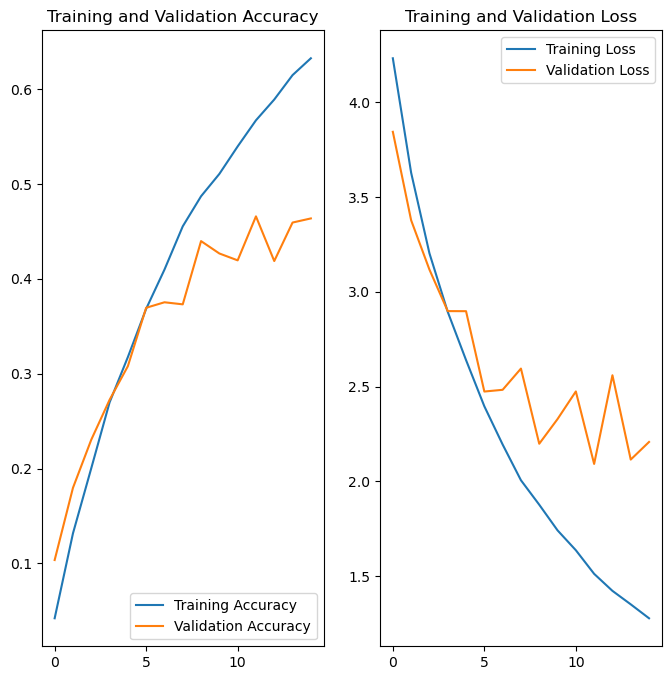

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
sunflower_url = "https://www.shutterstock.com/shutterstock/photos/1693796800/display_1500/stock-photo-single-neem-leaf-isolated-on-white-background-1693796800.jpg"
sunflower_path = tf.keras.utils.get_file('Amdldaa', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(np.argmax(score))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
12
This image most likely belongs to Mangifera Indica (Mango) with a 100.00 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))